In [1]:
#@title ⚙️ Install dependencies (20‑30 s)
!pip install -q grad-cam lime scikit-image tqdm pillow

# torch & torchvision are pre‑installed on Colab GPUs; pull latest for CUDA 12 if needed:
# !pip install -q torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

import os, json, pickle, requests, math, time, random, pathlib, numpy as np
from pathlib import Path
import torch, torchvision
from torchvision import transforms
from PIL import Image
print("✅ Imports ready ─ Torch", torch.__version__)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 47.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 15.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
# #@title 📁 Create folders & download 10 ImageNet sample images
# WORKDIR   = Path("/content/TML25_A4")
# IMGDIR    = WORKDIR / "images"
# for p in (WORKDIR, IMGDIR): p.mkdir(parents=True, exist_ok=True)

# IMAGES = {
#  "West_Highland_white_terrier":"https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02098105_2760.JPEG",
#  "American_coot":"https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01514668_8564.JPEG",
#  "racer":"https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02835271_1271.JPEG",
#  "flamingo":"https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n02007558_2514.JPEG",
#  "kite":"https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n03127747_1396.JPEG",
#  "goldfish":"https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01443537_931.JPEG",
#  "tiger_shark":"https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01494475_1239.JPEG",
#  "vulture":"https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01882714_4168.JPEG",
#  "common_iguana":"https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n01682714_4573.JPEG",
#  "orange":"https://raw.githubusercontent.com/EliSchwartz/imagenet-sample-images/master/n07747607_894.JPEG"
# }

# for name,url in IMAGES.items():
#     dest = IMGDIR/f"{name}.jpg"
#     if not dest.exists():
#         !wget -q {url} -O {dest}
# print("✅ Downloaded", len(list(IMGDIR.glob('*.jpg'))), "images")


In [3]:
#@title 🧠 Load pretrained ResNet‑18 (+ transforms) on GPU
from torchvision.models import resnet18, ResNet18_Weights
weights18   = ResNet18_Weights.IMAGENET1K_V1
model       = resnet18(weights=weights18).eval().cuda()
preprocess  = weights18.transforms()                 # resize‑crop‑norm pipeline
print("✅ Model loaded")


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 80.2MB/s]


✅ Model loaded


In [4]:
#@title 📥 Clone & copy images from the official repo
import os, shutil
from pathlib import Path

# 1. Clone the repo (only once; fast with --depth=1)
if not Path("/content/imagenet-sample-images").exists():
    !git clone --depth 1 https://github.com/EliSchwartz/imagenet-sample-images.git /content/imagenet-sample-images

# 2. Prepare your workspace
WORKDIR = Path("/content/TML25_A4")
IMGDIR  = WORKDIR/"images"
for d in (WORKDIR, IMGDIR):
    d.mkdir(parents=True, exist_ok=True)

# 3. List of your keys
keys = [
    "West_Highland_white_terrier",
    "American_coot",
    "racer",
    "flamingo",
    "kite",
    "goldfish",
    "tiger_shark",
    "vulture",
    "common_iguana",
    "orange"
]

# 4. Copy matching files from the clone into your IMGDIR, renaming to key.jpg
SRC = Path("/content/imagenet-sample-images")
for key in keys:
    # look for a filename containing the lowercase key tokens
    token = key.lower()
    candidates = [f for f in os.listdir(SRC) if token in f.lower()]
    if not candidates:
        raise FileNotFoundError(f"No sample‑image found for '{key}' in the clone.")
    # take the first match
    src_file = SRC/candidates[0]
    dst_file = IMGDIR/f"{key}.jpg"
    shutil.copy(src_file, dst_file)
    print(f"✅  Copied {candidates[0]} → {dst_file.name}")

print("\n🎉 All images are now valid JPEGs in", IMGDIR)


Cloning into '/content/imagenet-sample-images'...
remote: Enumerating objects: 1004, done.
remote: Counting objects: 100% (1004/1004), done.
remote: Compressing objects: 100% (1004/1004), done.
remote: Total 1004 (delta 0), reused 1000 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (1004/1004), 103.80 MiB | 37.00 MiB/s, done.
✅  Copied n02098286_West_Highland_white_terrier.JPEG → West_Highland_white_terrier.jpg
✅  Copied n02018207_American_coot.JPEG → American_coot.jpg
✅  Copied n04037443_racer.JPEG → racer.jpg
✅  Copied n02007558_flamingo.JPEG → flamingo.jpg
✅  Copied n01608432_kite.JPEG → kite.jpg
✅  Copied n01443537_goldfish.JPEG → goldfish.jpg
✅  Copied n01491361_tiger_shark.JPEG → tiger_shark.jpg
✅  Copied n01616318_vulture.JPEG → vulture.jpg
✅  Copied n01677366_common_iguana.JPEG → common_iguana.jpg
✅  Copied n07747607_orange.JPEG → orange.jpg

🎉 All images are now valid JPEGs in /content/TML25_A4/images


In [5]:
# 🔥  Grad‑CAM family  ─ works with grad‑cam ≥1.5
import torch, numpy as np
from pathlib import Path
from PIL import Image
from pytorch_grad_cam import GradCAM, ScoreCAM, AblationCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# 1️⃣  Device & model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 2️⃣  Target layer & CAM classes
target_layer = model.layer4[-1]
cams         = {"grad": GradCAM, "score": ScoreCAM, "ablation": AblationCAM}

# 3️⃣  Prepare output dict
heatmaps = {name: {} for name in cams}

# 4️⃣  Loop over each CAM variant and each image file
for cam_name, CamClass in cams.items():
    with CamClass(model=model, target_layers=[target_layer]) as cam:
        for img_path in Path("/content/TML25_A4/images").glob("*.jpg"):
            key = img_path.stem                  # e.g. "goldfish"
            rgb = Image.open(img_path).convert("RGB")
            inp = preprocess(rgb).unsqueeze(0).to(device)

            # compute the raw CAM heatmap (H×W float32 in [0,1])
            grayscale_cam = cam(input_tensor=inp)[0]

            # overlay on the original resized image
            vis = show_cam_on_image(
                np.array(rgb.resize((224,224))) / 255.0,
                grayscale_cam,
                use_rgb=True
            )

            # store both for later use
            heatmaps[cam_name][key] = {
                "cam":     grayscale_cam,
                "overlay": vis
            }

print("✅ CAMs computed for variants:", list(heatmaps.keys()))


100%|██████████| 16/16 [00:00<00:00, 37.35it/s]

✅ CAMs computed for variants: ['grad', 'score', 'ablation']


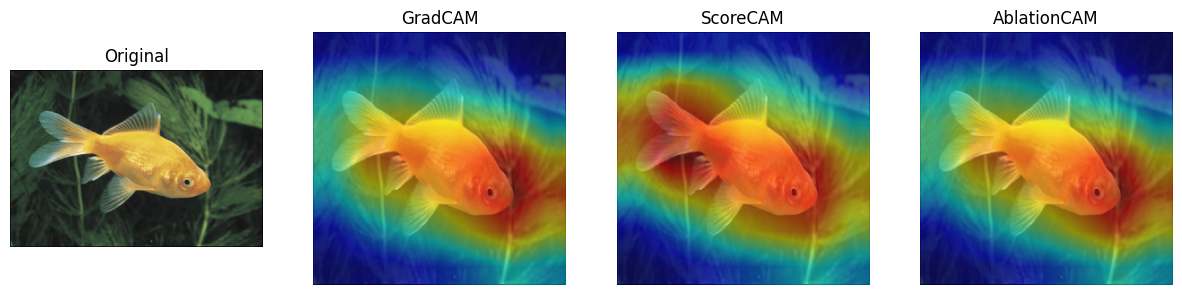

✅  Saved overlays to /content/TML25_A4/figs/gradcam


In [6]:
#@title 📸 Display & save Grad‑CAM variants for one image
import matplotlib.pyplot as plt

key = "goldfish"  # pick any of your 10 keys
variants = ["grad","score","ablation"]

fig, axes = plt.subplots(1, len(variants)+1, figsize=(15,5))
# show original
axes[0].imshow(Image.open(f"/content/TML25_A4/images/{key}.jpg"))
axes[0].set_title("Original")
axes[0].axis("off")

for i, v in enumerate(variants, 1):
    axes[i].imshow(heatmaps[v][key]["overlay"])
    axes[i].set_title(v.capitalize()+"CAM")
    axes[i].axis("off")
plt.show()

# Save all overlays for your report
outdir = Path("/content/TML25_A4/figs/gradcam")
outdir.mkdir(parents=True, exist_ok=True)
for v in variants:
    img = heatmaps[v][key]["overlay"]
    Image.fromarray(img).save(outdir/f"{key}_{v}.png")
print("✅  Saved overlays to", outdir)


In [7]:
# 🍋 Run LIME (with no_grad) and build masks/params
from lime import lime_image
from skimage.segmentation import quickshift

explainer = lime_image.LimeImageExplainer(random_state=42)
lime_params_all = {}
lime_masks = {}

def classifier_fn(img_list):
    # img_list is a list of H×W×3 numpy arrays
    batch = torch.stack([preprocess(Image.fromarray(i)) for i in img_list]).cuda()
    with torch.no_grad():                    # <<< disable grad
        logits = model(batch).softmax(1)
    return logits.detach().cpu().numpy()     # <<< detach before numpy

for img_path in Path("/content/TML25_A4/images").glob("*.jpg"):
    key = img_path.stem
    img_np = np.array(Image.open(img_path).convert("RGB"))

    explanation = explainer.explain_instance(
        image           = img_np,
        classifier_fn   = classifier_fn,
        labels          = (0,),
        top_labels      = 5,
        hide_color      = 0,
        num_features    = 1000,
        num_samples     = 1000,
        segmentation_fn = lambda x: quickshift(x, kernel_size=4, max_dist=200, ratio=0.2),
        batch_size      = 10
    )

    # Build param dict for server
    lime_params_all[key] = {
        "labels":         (0,),
        "hide_color":     0,
        "top_labels":     5,
        "num_features":   1000,
        "num_samples":    1000,
        "batch_size":     10,
        "segmentation_fn": None,
        "distance_metric": "cosine",
        "model_regressor": None,
        "random_seed":    None
    }

    # Extract binary mask for IoU
    _, mask = explanation.get_image_and_mask(
        explanation.top_labels[0],
        positive_only=True,
        num_features=1000,
        hide_rest=False
    )
    lime_masks[key] = (mask > 0).astype(np.uint8)

print("✅ LIME complete with no_grad; built params & masks for", list(lime_params_all.keys()))


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

✅ LIME complete with no_grad; built params & masks for ['tiger_shark', 'common_iguana', 'goldfish', 'orange', 'West_Highland_white_terrier', 'racer', 'kite', 'flamingo', 'vulture', 'American_coot']


In [8]:
#@title ⬆️ Upload explain_params.pkl
import pickle, requests
from pathlib import Path

TOKEN = "13602610"  # ← your token
OUTDIR = Path("/content/TML25_A4")
OUTDIR.mkdir(exist_ok=True)
pkl_path = OUTDIR/"explain_params.pkl"

# Save pickle
with open(pkl_path, "wb") as f:
    pickle.dump(lime_params_all, f)
print("✅ Pickle written to", pkl_path)

# POST to server
with open(pkl_path, "rb") as f:
    resp = requests.post(
        "http://34.122.51.94:9091/lime",
        files={"file": f},
        headers={"token": TOKEN}
    )
print("Server response:", resp.json())


✅ Pickle written to /content/TML25_A4/explain_params.pkl
Server response: {'avg_iou': 0.2773358632878968, 'avg_time': 4.623337697982788}


In [9]:
#@title 📊 Compute IoU with shape‑match (224×224)
import numpy as np
import pandas as pd
from PIL import Image

def binarize_cam(cam, pct=90):
    th = np.percentile(cam, pct)
    return (cam >= th).astype(np.uint8)

ious = {}
for key, mask_lime in lime_masks.items():
    # 1) Grad‑CAM mask (already 224×224)
    cam = heatmaps["grad"][key]["cam"]
    mask_cam = binarize_cam(cam, pct=90)

    # 2) Resize LIME mask from original → 224×224
    #    mask_lime is a numpy array (H×W)
    lime_img = Image.fromarray((mask_lime*255).astype(np.uint8))
    lime_resized = np.array(
        lime_img.resize((224, 224), resample=Image.NEAREST)
    )  # still 0 or 255
    mask_lime224 = (lime_resized > 0).astype(np.uint8)

    # 3) Compute IoU
    inter = (mask_cam & mask_lime224).sum()
    union = (mask_cam | mask_lime224).sum()
    ious[key] = float(inter) / union if union else 0.0

# Build DataFrame & save
df_iou = pd.DataFrame.from_dict(ious, orient="index", columns=["IoU"])
df_iou.loc["mean"] = df_iou.mean()
print(df_iou)

# Optional: save CSV
csv_path = Path("/content/TML25_A4/ious_resized.csv")
df_iou.to_csv(csv_path)
print("✅ Saved resized IoU table to", csv_path)


                                  IoU
tiger_shark                  0.110683
common_iguana                0.135941
goldfish                     0.120556
orange                       0.100192
West_Highland_white_terrier  0.108556
racer                        0.110875
kite                         0.101476
flamingo                     0.100325
vulture                      0.088358
American_coot                0.115046
mean                         0.109201
✅ Saved resized IoU table to /content/TML25_A4/ious_resized.csv


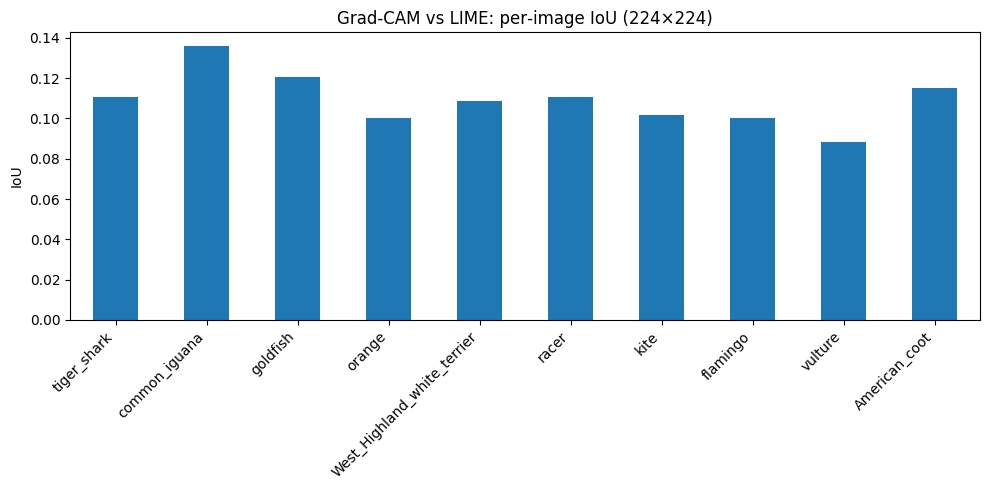

✅ Saved bar chart to /content/TML25_A4/figs/iou_bar.png


In [10]:
#@title 📈 Plot & save IoU bar chart
import matplotlib.pyplot as plt
from pathlib import Path

# Load the resized IoU table (or use df_iou from last cell)
# If you just ran the resizing cell, df_iou is still in memory.
# Otherwise uncomment the load step:
# import pandas as pd
# df_iou = pd.read_csv("/content/TML25_A4/ious_resized.csv", index_col=0)

# Drop the “mean” row for individual bars
df_plot = df_iou.drop("mean")

fig, ax = plt.subplots(figsize=(10,5))
df_plot.plot.bar(ax=ax, legend=False)
ax.set_ylabel("IoU")
ax.set_title("Grad‑CAM vs LIME: per‑image IoU (224×224)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()

# Save to disk for your report
outdir = Path("/content/TML25_A4/figs")
outdir.mkdir(parents=True, exist_ok=True)
fig_path = outdir/"iou_bar.png"
fig.savefig(fig_path)
plt.show()

print(f"✅ Saved bar chart to {fig_path}")


In [11]:
#@title 📸 Export all CAM & LIME overlays
from pathlib import Path
from PIL import Image
import numpy as np

BASE = Path("/content/TML25_A4/figs")
CAM_DIR  = BASE/"gradcam"
LIME_DIR = BASE/"lime"
CAM_DIR.mkdir(parents=True, exist_ok=True)
LIME_DIR.mkdir(parents=True, exist_ok=True)

# Grad‑CAM variants
for variant, imgs in heatmaps.items():
    subdir = CAM_DIR/variant
    subdir.mkdir(exist_ok=True)
    for key, data in imgs.items():
        img = data["overlay"]  # H×W×3 uint8
        Image.fromarray(img).save(subdir/f"{key}_{variant}.png")

# LIME (semi‑transparent red)
for key, mask in lime_masks.items():
    img = np.array(Image.open(Path("/content/TML25_A4/images")/f"{key}.jpg"))
    overlay = img.copy()
    overlay[mask==1] = (overlay[mask==1]*0.5 + np.array([255,0,0])*0.5).astype(np.uint8)
    Image.fromarray(overlay).save(LIME_DIR/f"{key}_lime.png")

print("✅ Saved all overlays under", BASE)


✅ Saved all overlays under /content/TML25_A4/figs
